DDPM : Denoising Diffusion Probabilistic Models

- Ref: 
    - DDPM: https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/tree/main/Denoising_Diffusion_Probabilistic_Models



In [1]:
import os
import torch
import torch.nn as nn
import numpy as np

import math
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchsummary import summary
import torchshow as ts

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torchvision.transforms.functional as F
from pathlib import Path

from torch.utils.data import Dataset, Subset, random_split
import time
import random

from torch.utils.tensorboard import SummaryWriter



In [2]:
## Unet network model
# Ref: https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/blob/main/Denoising_Diffusion_Probabilistic_Models/unet.py

def get_timestep_embedding(timesteps, embedding_dim: int):
    """
    Retrieved from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py#LL90C1-L109C13
    """
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps.type(torch.float32)[:, None] * emb[None, :]
    emb = torch.concat([torch.sin(emb), torch.cos(emb)], axis=1)

    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))

    assert emb.shape == (timesteps.shape[0], embedding_dim), f"{emb.shape}"
    return emb


class Downsample(nn.Module):

    def __init__(self, C):
        """
        :param C (int): number of input and output channels
        """
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, stride=2, padding=1)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.conv(x)
        assert x.shape == (B, C, H // 2, W // 2)
        return x


class Upsample(nn.Module):

    def __init__(self, C):
        """
        :param C (int): number of input and output channels
        """
        super(Upsample, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, stride=1, padding=1)

    def forward(self, x):
        B, C, H, W = x.shape

        x = nn.functional.interpolate(x, size=None, scale_factor=2, mode='nearest')

        x = self.conv(x)
        assert x.shape == (B, C, H * 2, W * 2)
        return x


class Nin(nn.Module):

    def __init__(self, in_dim, out_dim, scale=1e-10):
        super(Nin, self).__init__()

        n = (in_dim + out_dim) / 2
        limit = np.sqrt(3 * scale / n)
        self.W = torch.nn.Parameter(torch.zeros((in_dim, out_dim), dtype=torch.float32
                                                ).uniform_(-limit, limit))
        self.b = torch.nn.Parameter(torch.zeros((1, out_dim, 1, 1), dtype=torch.float32))

    def forward(self, x):
        return torch.einsum('bchw, co->bohw', x, self.W) + self.b


class ResNetBlock(nn.Module):

    def __init__(self, in_ch, out_ch, dropout_rate=0.1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
        self.dense = nn.Linear(512, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1)

        if not (in_ch == out_ch):
            self.nin = Nin(in_ch, out_ch)

        self.dropout_rate = dropout_rate
        self.nonlinearity = torch.nn.SiLU()

    def forward(self, x, temb):
        """
        :param x: (B, C, H, W)
        :param temb: (B, dim)
        """

        h = self.nonlinearity(nn.functional.group_norm(x, num_groups=32))
        h = self.conv1(h)

        # add in timestep embedding
        h += self.dense(self.nonlinearity(temb))[:, :, None, None]

        h = self.nonlinearity(nn.functional.group_norm(h, num_groups=32))
        h = nn.functional.dropout(h, p=self.dropout_rate)
        h = self.conv2(h)

        if not (x.shape[1] == h.shape[1]):
            x = self.nin(x)

        assert x.shape == h.shape
        return x + h


class AttentionBlock(nn.Module):

    def __init__(self, ch):
        super(AttentionBlock, self).__init__()

        self.Q = Nin(ch, ch)
        self.K = Nin(ch, ch)
        self.V = Nin(ch, ch)

        self.ch = ch

        self.nin = Nin(ch, ch, scale=0.)

    def forward(self, x):
        B, C, H, W = x.shape
        assert C == self.ch

        h = nn.functional.group_norm(x, num_groups=32)
        q = self.Q(h)
        k = self.K(h)
        v = self.V(h)

        w = torch.einsum('bchw,bcHW->bhwHW', q, k) * (int(C) ** (-0.5))  # [B, H, W, H, W]
        w = torch.reshape(w, [B, H, W, H * W])
        w = torch.nn.functional.softmax(w, dim=-1)
        w = torch.reshape(w, [B, H, W, H, W])

        h = torch.einsum('bhwHW,bcHW->bchw', w, v)
        h = self.nin(h)

        assert h.shape == x.shape
        return x + h


class UNet(nn.Module):

    def __init__(self, ch=128, in_ch=1):
        super(UNet, self).__init__()

        self.ch = ch
        self.linear1 = nn.Linear(ch, 4 * ch)
        self.linear2 = nn.Linear(4 * ch, 4 * ch)

        self.conv1 = nn.Conv2d(in_ch, ch, 3, stride=1, padding=1)

        self.down = nn.ModuleList([ResNetBlock(ch, 1 * ch),
                                   ResNetBlock(1 * ch, 1 * ch),
                                   Downsample(1 * ch),
                                   ResNetBlock(1 * ch, 2 * ch),
                                   AttentionBlock(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   AttentionBlock(2 * ch),
                                   Downsample(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   Downsample(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch)])

        self.middle = nn.ModuleList([ResNetBlock(2 * ch, 2 * ch),
                                     AttentionBlock(2 * ch),
                                     ResNetBlock(2 * ch, 2 * ch)])

        self.up = nn.ModuleList([ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 ResNetBlock(3 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(3 * ch, ch),
                                 ResNetBlock(2 * ch, ch),
                                 ResNetBlock(2 * ch, ch)])

        self.final_conv = nn.Conv2d(ch, in_ch, 3, stride=1, padding=1)

    def forward(self, x, t):
        """
        :param x: (torch.Tensor) batch of images [B, C, H, W]
        :param t: (torch.Tensor) tensor of time steps (torch.long) [B]
        """

        temb = get_timestep_embedding(t, self.ch)
        temb = torch.nn.functional.silu(self.linear1(temb))
        temb = self.linear2(temb)
        assert temb.shape == (t.shape[0], self.ch * 4)

        x1 = self.conv1(x)

        # Down
        x2 = self.down[0](x1, temb)
        x3 = self.down[1](x2, temb)
        x4 = self.down[2](x3)
        x5 = self.down[3](x4, temb)
        x6 = self.down[4](x5)  # Attention
        x7 = self.down[5](x6, temb)
        x8 = self.down[6](x7)  # Attention
        x9 = self.down[7](x8)
        x10 = self.down[8](x9, temb)
        x11 = self.down[9](x10, temb)
        x12 = self.down[10](x11)
        x13 = self.down[11](x12, temb)
        x14 = self.down[12](x13, temb)

        # Middle
        x = self.middle[0](x14, temb)
        x = self.middle[1](x)
        x = self.middle[2](x, temb)

        # Up
        x = self.up[0](torch.cat((x, x14), dim=1), temb)
        x = self.up[1](torch.cat((x, x13), dim=1), temb)
        x = self.up[2](torch.cat((x, x12), dim=1), temb)
        x = self.up[3](x)
        x = self.up[4](torch.cat((x, x11), dim=1), temb)
        x = self.up[5](torch.cat((x, x10), dim=1), temb)
        x = self.up[6](torch.cat((x, x9), dim=1), temb)
        x = self.up[7](x)
        x = self.up[8](torch.cat((x, x8), dim=1), temb)
        x = self.up[9](x)
        x = self.up[10](torch.cat((x, x6), dim=1), temb)
        x = self.up[11](x)
        x = self.up[12](torch.cat((x, x4), dim=1), temb)
        x = self.up[13](x)
        x = self.up[14](x)
        x = self.up[15](torch.cat((x, x3), dim=1), temb)
        x = self.up[16](torch.cat((x, x2), dim=1), temb)
        x = self.up[17](torch.cat((x, x1), dim=1), temb)

        x = nn.functional.silu(nn.functional.group_norm(x, num_groups=32))
        x = self.final_conv(x)

        return x


- DDPM
    - ![DDPM](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FRXOe5%2Fbtru2nyl2SU%2FzkLx0SMgf1qpaI01kCmGu1%2Fimg.png)

- DDPM vs. DDIM
    - ![](https://kimjy99.github.io/assets/img/ddim/ddim-markovian.webp)
    - $x_{t-1} = \sqrt{\alpha_{t-1}} \underbrace{\bigg( \frac{x_t - \sqrt{1-\alpha_t} \epsilon_\theta^{(t)} (x_t)}{\sqrt{\alpha_t}} \bigg)}_{\textrm{predicted } x_0} + \underbrace{\sqrt{1-\alpha_{t-1} -\sigma_t^2} \cdot \epsilon_\theta^{(t)} (x_t)}_{\textrm{direction pointing to } x_t}+ \underbrace{\sigma_t \epsilon_t}_{\textrm{random noise}}$ 
    - if $\sigma_t = \sqrt{\frac{1-\alpha_{t-1}}{1-\alpha_t}} \sqrt{1 - \frac{\alpha_t}{\alpha_{t-1}}}$, Generative process -> DDPM

In [3]:
# Diffusion Model

class DiffusionModel:

    def __init__(self, T: int, model: nn.Module, device: str):
        self.T = T
        self.function_approximator = model.to(device)
        self.device = device

        self.beta = torch.linspace(1e-4, 0.02, T).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

        # DPM_SOLVER
        self.alphas = torch.sqrt(self.alpha_bar)
        self.sigmas = torch.sqrt(1.0 - self.alpha_bar)
        self.lambdas = torch.log(self.alphas / self.sigmas)

    def training(self, x0, batch_size, optimizer):
        """
        Algorithm 1 in Denoising Diffusion Probabilistic Models
        """
        # with torch.autocast(device_type='cuda', dtype=torch.float16):
            # x0 = sample_batch(batch_size, self.device)
        t = torch.randint(1, self.T + 1, (batch_size,), device=self.device,
                        dtype=torch.long)
        eps = torch.randn_like(x0)

        # Take one gradient descent step
        alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(
            -1).unsqueeze(-1)
        eps_predicted = self.function_approximator(torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * eps, t - 1)
        loss = nn.functional.mse_loss(eps, eps_predicted)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()


    def training_2(self, x0, batch_size, optimizer):
        """
        Algorithm 1 in Denoising Diffusion Probabilistic Models
        """
        t_list =  list(range(1, self.T + 1))
        random.shuffle(t_list)
        t_loss = 0
        for tidx in tqdm(t_list):

            # x0 = sample_batch(batch_size, self.device)
            # t = torch.randint(1, self.T + 1, (batch_size,), device=self.device,
            #                 dtype=torch.long)
            t = torch.ones((batch_size,), device=self.device, dtype=torch.long) * tidx
            eps = torch.randn_like(x0)

            # Take one gradient descent step
            alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(
                -1).unsqueeze(-1)
            eps_predicted = self.function_approximator(torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * eps, t - 1)
            loss = nn.functional.mse_loss(eps, eps_predicted)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t_loss += loss.item()

        return t_loss / self.T

    def training_3(self, x0, batch_size, optimizer):
        """
        Algorithm 1 in Denoising Diffusion Probabilistic Models
        """
        _t_list =  list(range(1, self.T + 1))
        t_list = random.sample(_t_list, self.T // 10)
        t_loss = 0
        for tidx in tqdm(t_list):

            # x0 = sample_batch(batch_size, self.device)
            # t = torch.randint(1, self.T + 1, (batch_size,), device=self.device,
            #                 dtype=torch.long)
            t = torch.ones((batch_size,), device=self.device, dtype=torch.long) * tidx
            eps = torch.randn_like(x0)

            # Take one gradient descent step
            alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(
                -1).unsqueeze(-1)
            eps_predicted = self.function_approximator(torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * eps, t - 1)
            loss = nn.functional.mse_loss(eps, eps_predicted)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t_loss += loss.item()

        return t_loss / len(t_list)

    @torch.no_grad()
    def sampling(self, n_samples=1, image_channels=1, img_size=(32, 32), sample_it = 10):
        """
        Algorithm 2 in Denoising Diffusion Probabilistic Models
        """
        t_lst = []
        x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]),
                        device=self.device)
        for it in tqdm(range(self.T, 0, -1), desc="Sampling"):
            if it % sample_it == 0:
                t_lst.append((it, x))
            z = torch.randn_like(x) if it > 1 else torch.zeros_like(x)
            t = torch.ones(n_samples, dtype=torch.long, device=self.device) * it

            beta_t = self.beta[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_t = self.alpha[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

            mean = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / torch.sqrt(
                1 - alpha_bar_t)) * self.function_approximator(x, t - 1))
            sigma = torch.sqrt(beta_t)
            x = mean + sigma * z
        t_lst.append((it-1, x))
        return x, t_lst

    @torch.no_grad()
    def ddpm_sampling(self, n_samples=1, image_channels=1, img_size=(32, 32),
                 use_tqdm=True):
        """
        Algorithm 2 in Denoising Diffusion Probabilistic Models
        """

        x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]),
                        device=self.device)
        progress_bar = tqdm if use_tqdm else lambda x: x
        # for t in progress_bar(range(self.T, 0, -1)):
        for t in tqdm(range(self.T, 0, -1), desc="DDPM Sampling"):
            z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
            t = torch.ones(n_samples, dtype=torch.long, device=self.device) * t

            beta_t = self.beta[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_t = self.alpha[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

            mean = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / torch.sqrt(
                1 - alpha_bar_t)) * self.function_approximator(x, t - 1))
            sigma = torch.sqrt(beta_t)
            x = mean + sigma * z
        return x

    @torch.no_grad()
    def ddim_sampling(self, n_samples=1, image_channels=1, img_size=(32, 32),
                      n_steps=50, use_tqdm=True):

        step_size = self.T // n_steps
        x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]),
                        device=self.device)
        progress_bar = tqdm if use_tqdm else lambda x: x

        # for i in progress_bar(range(n_steps)):
        for i in tqdm(range(n_steps), desc="DDIM Sampling"):
            t = self.T - i * step_size
            t_tensor = torch.ones(n_samples, dtype=torch.long, device=self.device) * t

            alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_bar_prev = self.alpha_bar[t - step_size - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) if t > step_size else torch.tensor(1.0).to(self.device)

            # Predicted noise
            eps_pred = self.function_approximator(x, t_tensor - 1)

            # Predicted x_0
            x0_pred = (x - torch.sqrt(1 - alpha_bar_t) * eps_pred) / torch.sqrt(alpha_bar_t)

            # Direction pointing to xt
            dir_xt = torch.sqrt(1 - alpha_bar_prev) * eps_pred

            # Update rule
            x = torch.sqrt(alpha_bar_prev) * x0_pred + dir_xt

        return x

    @torch.no_grad()
    def dpm_solver_sampling(self, n_samples=1, image_channels=1, img_size=(32, 32), n_steps=10, use_tqdm=True):
        """
        DPM-Solver-2 (Algorithm 1 from https://arxiv.org/pdf/2206.00927).
        """
        step_size = self.T // n_steps
        # start from Gaussian noise x_T
        xT = torch.randn((n_samples, image_channels, img_size[0], img_size[1]), device=self.device)
        x_tilde = xT

        for i in tqdm(range(n_steps), desc="DPM-Solver Sampling", disable=not use_tqdm):

            t_prev = self.T - i * step_size
            t_cur = max(t_prev - step_size, 1)

            # midpoint in λ-space
            lam_mid = (self.lambdas[t_prev - 1] + self.lambdas[t_cur - 1]) / 2.
            # invert λ→t via nearest neighbor lookup
            s_i = torch.argmin(torch.abs(self.lambdas - lam_mid)).item() + 1

            # λ-step size
            h = self.lambdas[t_cur - 1] - self.lambdas[t_prev - 1]

            # model evaluation at t_prev
            t_prev_tensor = torch.full((n_samples,), t_prev, dtype=torch.long, device=self.device)
            u_i = (self.alphas[s_i - 1] / self.alphas[t_prev - 1]) * x_tilde - self.sigmas[s_i - 1] * (
                torch.exp(h * 0.5) - 1) * self.function_approximator(x_tilde, t_prev_tensor - 1)

            t_s_tensor = torch.full((n_samples,), s_i, dtype=torch.long, device=self.device)
            x_tilde = (self.alphas[t_cur - 1] / self.alphas[t_prev - 1]) * x_tilde - self.sigmas[t_cur - 1] * (
                torch.exp(h) - 1) * self.function_approximator(u_i, t_s_tensor - 1)

        return x_tilde

In [4]:
if torch.backends.mps.is_available():
    g_device = torch.device("mps")
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
elif torch.cuda.is_available():
    g_device = torch.device("cuda")
else:
    g_device = torch.device("cpu")
print(g_device)

Current memory allocated on MPS: 0 bytes
Driver memory allocated on MPS: 393216 bytes
mps


In [5]:

def save_video(img_t_lst, nrows = 9, ncols = 9, v_fp = "test.mp4"):
    # fig, axes = plt.subplots(nrows, ncols, figsize=(6, 6))
    fig, axes = plt.subplots(nrows, ncols)
    ims = []
    for i, imt in img_t_lst:
        frame_ims = []
        if not isinstance(i, int):
            i = i[0]
        for j, ax in enumerate(axes.flat):
            # print(f"{i}_{j}")
            # ax.set_title(f"{i}_{j}")
            ax.axis('off')
            img_n = (imt[j].to("cpu") + 1) * 0.5
            img_n = F.to_pil_image(img_n.clip(0, 1))
            frame_ims.append(ax.imshow(img_n, cmap='gray'))
            # frame_ims.append(ax.imshow(F.to_pil_image(imt[j].to("cpu").clip(0, 1)), cmap='gray'))
        ims.append(frame_ims)
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    # vfp = os.path.join(g_video_path, v_fname)
    ani.save(v_fp, writer="ffmpeg", fps=10)



def save_video_01(img_t_lst, nrows = 9, ncols = 9, v_fp = "test.mp4"):
    # fig, axes = plt.subplots(nrows, ncols, figsize=(6, 6))
    fig, axes = plt.subplots(nrows, ncols)
    ims = []
    for i, imt in img_t_lst:
        frame_ims = []
        if not isinstance(i, int):
            i = i[0]
        for j, ax in enumerate(axes.flat):
            # print(f"{i}_{j}")
            # ax.set_title(f"{i}_{j}")
            ax.axis('off')
            img_n = (imt[j].to("cpu") + 1) * 0.5
            img_n = F.to_pil_image(img_n.clip(0, 1))
            frame_ims.append(ax.imshow(img_n, cmap='gray'))
            # frame_ims.append(ax.imshow(F.to_pil_image(imt[j].to("cpu").clip(0, 1)), cmap='gray'))
        ims.append(frame_ims)
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    # vfp = os.path.join(g_video_path, v_fname)
    ani.save(v_fp, writer="ffmpeg", fps=10)

torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


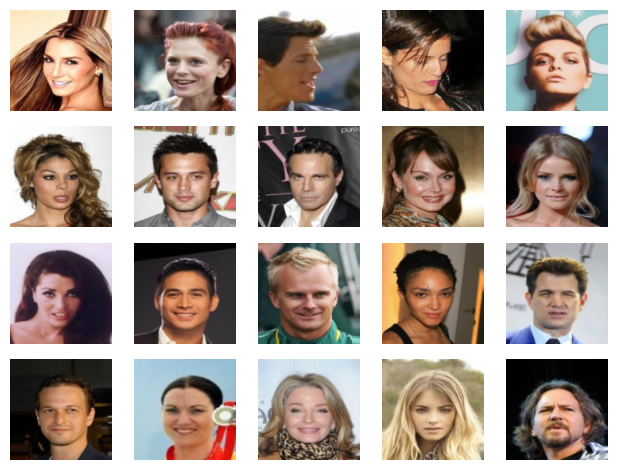

In [6]:
# 0 - 1

g_model_path = './temp/01.Diffusion_CelebA_models/'
g_video_path = './temp/01.Diffusion_CelebA_videos/'
g_log_path = './temp/log/01.Diffusion_CelebA_logs/'
Path(g_model_path).mkdir(exist_ok=True, parents=True)
Path(g_video_path).mkdir(exist_ok=True, parents=True)
g_writer = SummaryWriter(g_log_path)

# parameters
n_steps = 1000
batch_size = 4
nsample = batch_size * 5
epoches = n_steps * nsample
eval_step = nsample
nb_images = 4
img_channel = 3

# datasets

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((128, 128),interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
                transforms.Normalize(mean=(0.5), std=(0.5)) # Normalizes to [-1, 1]
            ])
dataset = datasets.CelebA(root='./temp/data', split='train', download=True, transform = transform)
len(dataset)

data_sz = len(dataset)
subset_sz = int(data_sz * 0.0005)
indices = list(range(nsample))

img_lst = []
for i in indices:
    img_t = dataset[i][0]
    print(img_t.shape)
    img_t = (img_t + 1.0) * 0.5
    img_lst.append(torch.unsqueeze(img_t, 0))

img_lst = torch.concat(img_lst)
ts.show(img_lst)



In [ ]:

subset_dataset = Subset(dataset, indices)
dataloader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Setup Model
model = UNet(in_ch = img_channel)
model.to(g_device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
diffusion_model = DiffusionModel(n_steps, model, g_device)

# Training
loss_lst = []
loss_best = float('inf')
tq = tqdm(range(epoches), total = epoches, desc="Training")
for ep in tq:
    # print(f"Epoch - {ep}")
    # tq = tqdm(enumerate(dataloader), total = len(dataloader), desc="Training")
    loss_e = 0
    for i, x0, in enumerate(dataloader):
        x0 = x0[0].to(g_device)
        _loss = diffusion_model.training(x0, batch_size, optimizer)
        loss_lst.append(_loss)
        loss_e += _loss
        tq.set_description(f"Epoch - {ep} / {epoches}- Loss: {loss_e:.5f}; step {i}; epoch {ep}")
    g_writer.add_scalar("Loss/Sum", loss_e, ep)
    g_writer.add_scalar("Loss/AVG", loss_e/len(dataloader), ep)

    if loss_e < loss_best:
        print(f"best loss : {loss_e}")
        loss_best = loss_e
        _model_path = os.path.join(g_model_path, f'unet_best.pth')
        torch.save(diffusion_model.function_approximator.state_dict(), _model_path)

    _model_path = os.path.join(g_model_path, f'unet_last.pth')
    torch.save(diffusion_model.function_approximator.state_dict(), _model_path)


    diffusion_model.function_approximator.eval()
    if ep % (nsample*10) == 0 or ep == epoches-1:
        _, t_list = diffusion_model.sampling(n_samples=nb_images, image_channels=img_channel, img_size=(128, 128))
        vfp = os.path.join(g_video_path, f"test_{ep:03d}.mp4")
        save_video(t_list, 2, 2, vfp)

        st = time.time()
        samples = diffusion_model.ddpm_sampling(n_samples=nb_images, image_channels=img_channel, img_size=(128, 128), use_tqdm=True)
        # print(f"DDPM-Sampling {time.time() - st } seconds")
        ddpm_sampling_ts = time.time() - st
        img_op = os.path.join(g_video_path, f"ddpm_{ep:03d}.jpg")
        samples = (samples.to("cpu") + 1) * 0.5
        ts.save(samples, img_op, ncols = 2)

        st = time.time()
        samples = diffusion_model.ddim_sampling(n_samples=nb_images, image_channels=img_channel, img_size=(128, 128), use_tqdm=True)
        # print(f"DDIM-Sampling {time.time() - st } seconds")
        ddim_sampling_ts = time.time() - st
        img_op = os.path.join(g_video_path, f"ddim_{ep:03d}.jpg")
        samples = (samples.to("cpu") + 1) * 0.5
        ts.save(samples, img_op, ncols = 2)

        st = time.time()
        samples = diffusion_model.dpm_solver_sampling(n_samples=nb_images, n_steps=10, image_channels=img_channel, img_size=(128, 128), use_tqdm=True)
        # print(f"DPM-Solver-Sampling {time.time() - st } seconds")
        dpm_sampling_ts = time.time() - st
        img_op = os.path.join(g_video_path, f"dpm_solver_{ep:03d}.jpg")
        samples = (samples.to("cpu") + 1) * 0.5
        ts.save(samples, img_op, ncols = 2)

        print(f"ddpm - {ddpm_sampling_ts:.5f}, ddim - {ddim_sampling_ts:.5f}, dpm_sampling - {dpm_sampling_ts:.5f}")


    diffusion_model.function_approximator.train()

plt.plot(loss_lst)
plt.show()

## ddpm_sampling

DDPM Sampling: 100%|██████████| 1000/1000 [03:14<00:00,  5.14it/s]

DDPM-Sampling 194.66436409950256 seconds


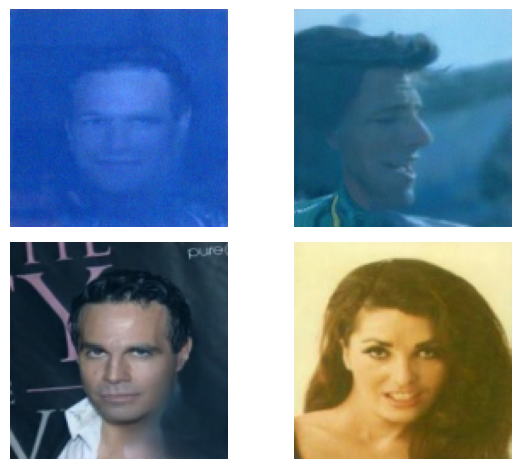

In [13]:
st = time.time()
samples = diffusion_model.ddpm_sampling(n_samples=nb_images, image_channels=img_channel, img_size=(128, 128), use_tqdm=True)
ddpm_sampling_ts = time.time() - st
# img_op = os.path.join(g_video_path, f"ddpm_{ep:03d}.jpg")
samples = (samples.to("cpu") + 1) * 0.5
print(f"DDPM-Sampling {ddpm_sampling_ts} seconds")
ts.show(samples)

DDIM Sampling: 100%|██████████| 50/50 [00:09<00:00,  5.19it/s]


DDPM-Sampling 9.64514422416687 seconds


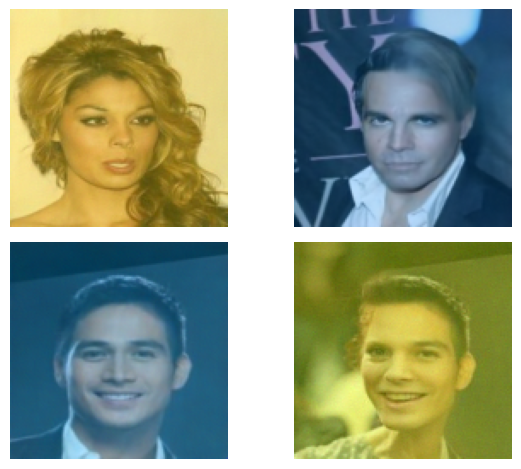

In [11]:
st = time.time()
samples = diffusion_model.ddim_sampling(n_samples=nb_images, image_channels=img_channel, img_size=(128, 128), use_tqdm=True)
ddim_sampling = time.time() - st
# img_op = os.path.join(g_video_path, f"ddpm_{ep:03d}.jpg")
samples = (samples.to("cpu") + 1) * 0.5
print(f"DDPM-Sampling {ddim_sampling} seconds")
ts.show(samples)

DPM-Solver Sampling: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]

DDPM-Sampling 3.9347288608551025 seconds


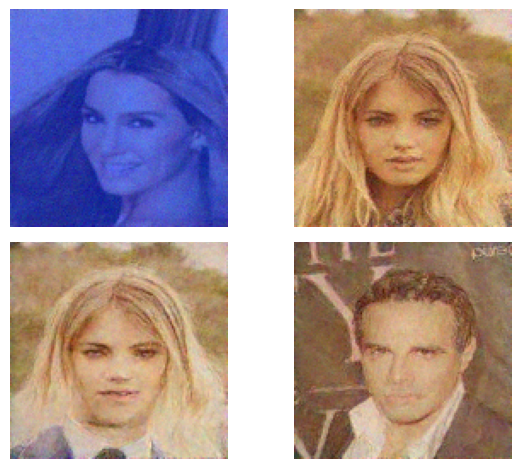

In [12]:
st = time.time()
samples = diffusion_model.dpm_solver_sampling(n_samples=nb_images, image_channels=img_channel, img_size=(128, 128), use_tqdm=True)
dpm_solver_sampling = time.time() - st
# img_op = os.path.join(g_video_path, f"ddpm_{ep:03d}.jpg")
samples = (samples.to("cpu") + 1) * 0.5
print(f"DDPM-Sampling {dpm_solver_sampling} seconds")
ts.show(samples)